# Homework assignment for ARIA image course 

In [121]:
import torch 
import torchvision.transforms.v2 as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [122]:
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True), 
    transforms.Normalize((0.5,), (0.5,))
    ])

In [123]:
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

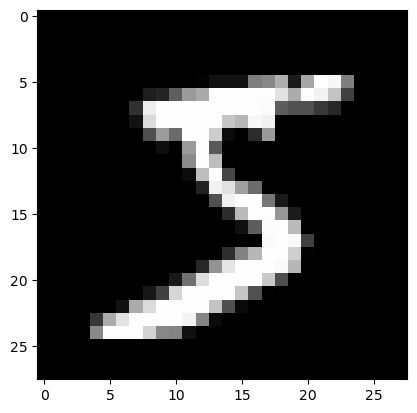

In [124]:
plt.imshow(train_dataset[0][0].squeeze(), cmap='gray')

## PART 1 : Classification with CNN on MNIST

For the purpouse of learning and experimentation, we implement different CNN architecture and compare there efficiency on the MNIST classification task.

### Architecture 1 :  LeNet 

LeNet is the architecture described in the pratical session. It is one of the first CNN built by LeCun in the 1990's and proved well on MNIST despite simplicity. The architecture of the NN is the following : 

- Layer 1 : Convolution layer with 6 output channels and 5x5 filter (1x28x28 -> 6x24x24) 
- Layer 2 : Average pool of size 2x2 (6x24x24 -> 6x12x12)
- Layer 3 : Convolution with 16 outplut channels and 5x5 filter (6x12x12 -> 16x8x8)
- Layer 4 : Average pool of size 2x2 (16x8x8 -> 16x4x4 flattened to 256)
- Layer 5 : Fully connected (256 -> 84)
- Layer 6 : Fully connected (84 -> 10)


In [125]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.avgpool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.avgpool2 = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Define the network
        self.net = nn.Sequential(
            self.conv1, nn.ReLU(),
            self.avgpool1,
            self.conv2, nn.ReLU(),
            self.avgpool2, 
            nn.Flatten(),
            self.fc1, nn.ReLU(),
            self.fc2, nn.ReLU(),
            self.fc3
        )

    def forward(self, x):
        return self.net(x)


In [126]:
model_LeNet = LeNet()
model_LeNet.to(device)
model_LeNet

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

We now train the our model on the MNIST dataset using crossentropy loss : $$\mathcal{L}(p_{data},p_\theta) = -\mathbb{E}_{X \sim p_{data}}[\log(p_\theta(X))]$$


In [127]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_LeNet.parameters(), lr=0.001)

In [164]:
epochs = 10
avg_loss_list = []

def train_one_epoch():
    model_LeNet.train()  # Set model to training mode
    running_loss = 0.0
    total_batches = 0

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move both to device
        
        optimizer.zero_grad()
        outputs = model_LeNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_batches += 1
        
        if i % 100 == 99:    
            avg_loss = running_loss / total_batches
            avg_loss_list.append(avg_loss)
            running_loss = 0.0
            total_batches = 0


In [ ]:
for epoch in range(epochs):
    train_one_epoch()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

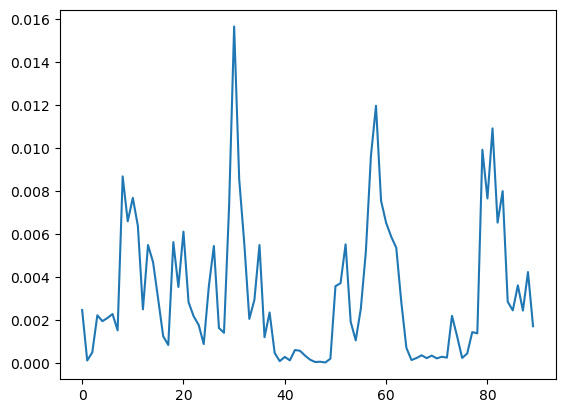

In [166]:
plt.plot(avg_loss_list)

In [167]:
def evaluate(): 
    model_LeNet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_LeNet(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

evaluate()
            

Accuracy of the model on the 10000 test images: 99.15%


### Architecture 2 : VGG

### Architecture 3 : ResNet

## PART 2 : Generation of adverserial examples